In [18]:
from few_shot import *

from src.transformations import *
from src.model_trainer import ModelTrainer
from torchvision.models import resnet18, ResNet18_Weights
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

from torchvision import datasets
from torch.utils.data import DataLoader

import tqdm
import torch

gen = torch.Generator()
gen.manual_seed(123)

In [2]:
train_set = datasets.ImageFolder(root="./data/train", transform=resize_transform())
test_set = datasets.ImageFolder(root="./data/test", transform=resize_transform())

In [3]:
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.fc = nn.Flatten()
model = PrototypicalNetwork(resnet)

In [4]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

In [5]:
def get_labels(self):
    return [label for _, label in self.samples]


test_set.get_labels = get_labels.__get__(test_set)

In [7]:
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,  # OTHERWISE DOES NOT WORK
    collate_fn=test_sampler.episodic_collate_fn,
)

In [8]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

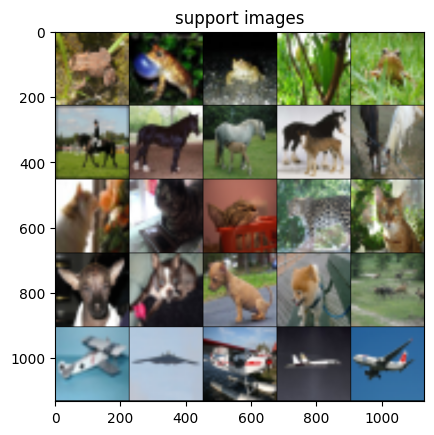

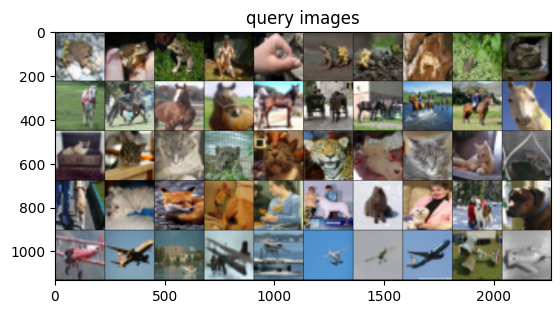

In [9]:
plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [10]:
model.eval()
example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.classes[example_class_ids[example_query_labels[i]]]} / {test_set.classes[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
frog / cat
frog / dog
frog / frog
frog / horse
frog / dog
frog / dog
frog / frog
frog / cat
frog / frog
frog / cat
horse / dog
horse / dog
horse / dog
horse / horse
horse / horse
horse / horse
horse / horse
horse / horse
horse / horse
horse / dog
cat / horse
cat / cat
cat / cat
cat / cat
cat / dog
cat / dog
cat / cat
cat / cat
cat / dog
cat / cat
dog / cat
dog / cat
dog / dog
dog / cat
dog / dog
dog / horse
dog / dog
dog / dog
dog / dog
dog / cat
airplane / cat
airplane / airplane
airplane / cat
airplane / airplane
airplane / horse
airplane / airplane
airplane / airplane
airplane / airplane
airplane / horse
airplane / dog


In [11]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images, support_labels, query_images).detach().data,
            1,
        )[1]
        == query_labels
    ).sum().item(), len(query_labels)

In [12]:
evaluate_on_one_task(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
)

(25, 50)

In [ ]:
def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):
            support_images = support_images.cpu()
            support_labels = support_labels.cpu()
            query_images = query_images.cpu()
            query_labels = query_labels.cpu()

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [04:43<00:00,  2.84s/it]

Model tested on 100 tasks. Accuracy: 49.54%


# Training

In [14]:
N_TRAINING_EPISODES = 2000
N_VALIDATION_TASKS = 100

train_set.get_labels = get_labels.__get__(train_set)

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [16]:
import torch.optim as optim

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(support_images, support_labels, query_images)

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [22]:
from tqdm import tqdm

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 2000/2000 [2:51:24<00:00,  5.14s/it, loss=0.537]  


In [30]:
evaluate(test_loader)

100%|██████████| 100/100 [08:17<00:00,  4.98s/it]

Model tested on 100 tasks. Accuracy: 77.46%


In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), "few_shot/few_shot_model_state.pth")

# Save additional training information
training_info = {
    "all_loss": all_loss,
    "model_config": {"n_way": N_WAY, "n_shot": N_SHOT, "n_query": N_QUERY},
}
torch.save(training_info, "few_shot/few_shot_training_results.pth")

print("Model and training results saved successfully.")

Model and training results saved successfully.
